<a href="https://colab.research.google.com/github/JAntonioRosales/CE888-Data-Science/blob/main/labs/lab_5/Lab5_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_wine

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

* We have loaded the necessary libraries above
* Now let's load the data

In [2]:
wine_data = load_wine(as_frame=True)
df = wine_data.data.copy()  # features
# Look at the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html)
# and save the label in a column called 'y' in df.
df['y'] = wine_data.target.copy()
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,y
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [8]:
#How many samples and features are there?

shape = df.shape
print('Number of samples:', shape[0], '\nNumber of features:', shape[1]-1)

Number of samples: 178 
Number of features: 13


In [9]:
# Quiz Q1
# How many instances are there for each class?

df['y'].value_counts()

1    71
0    59
2    48
Name: y, dtype: int64

In [10]:
# Calculate the means, medians, and standard deviations of each feature
df_nolabel = df.iloc[:, :-1].copy()
means = df_nolabel.mean(axis=0)
medians = df_nolabel.median(axis=0)
stdevs = df_nolabel.std(axis=0)
vals = np.vstack((means.values, medians.values, stdevs.values))
df_comparison = pd.DataFrame(data=vals, index=['mean', 'median', 'stdev'], columns=df_nolabel.columns)
df_comparison

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
median,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
stdev,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474


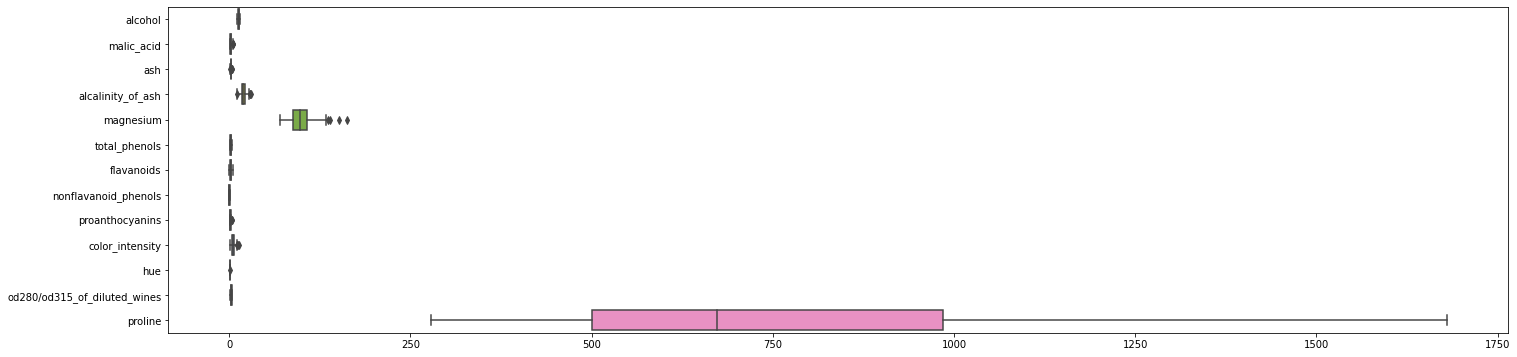

In [11]:
# Plot a boxplot of each feature (NOT THE LABEL!!) (all in one plot -- you can do this with a single line of code).
# Quiz Q2: Is there any feature that is in a clearly different scale than the others?

plt.figure(figsize=(24,6))
sns.boxplot(data=df_nolabel, orient="h")

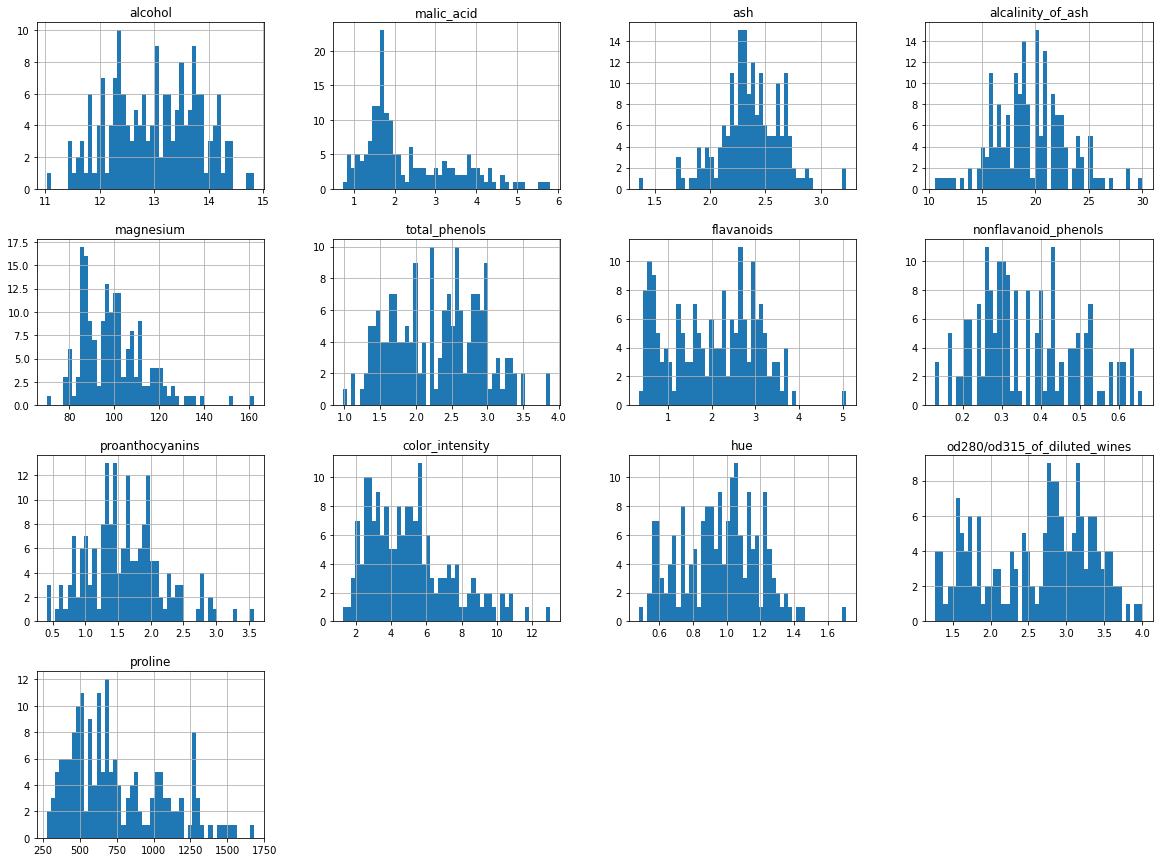

In [12]:
# Let's look at the distributions of values of our features. Draw a histogram for each of the features

blob = df_nolabel.hist(bins=50, figsize=(20,15))

Let's do some multivariate analysis

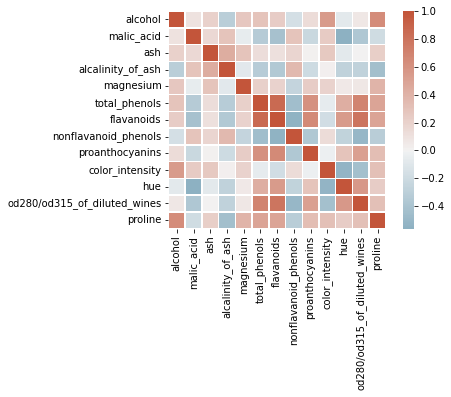

In [13]:
# Calculate the correlations between each pair of variables

#plt.figure(figsize=(20,20))
#for feat in range(1, df_nolabel.shape[1]):
#  plt.subplot(4,4,feat)
#  plt.scatter(df_nolabel.iloc[:, feat-1], df_nolabel.iloc[:, feat])
#  plt.xlabel(df_nolabel.columns[feat-1])
#  plt.ylabel(df_nolabel.columns[feat])
#plt.show()

df_corr = df_nolabel.corr()

# Plot a heatmap of the correlations between pairs of FEATURES (i.e., don't include the target!)

sns.heatmap(df_corr,
            center=0, square=True, linewidths=.5,
            cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.show()

In [14]:
# What is the highest correlation between features?

for feat in range(df_corr.shape[0]-1):
  feat_name = df_corr.columns[feat] # String of the feature name
  corr_vals = df_corr.iloc[:, feat].drop(index=[feat_name]) # Pandas Series for each feature without its correlation with itself
  max_pos_corr = corr_vals.max()
  max_pos_corr_feat = corr_vals.index[corr_vals == max_pos_corr]
  max_neg_corr = corr_vals.min()
  max_neg_corr_feat = corr_vals.index[corr_vals == max_neg_corr]
  print(feat_name, ':', max_pos_corr_feat[0], '(', max_pos_corr, ') ||', max_neg_corr_feat[0], '(', max_neg_corr, ')\n')

alcohol : proline ( 0.6437200371782134 ) || alcalinity_of_ash ( -0.310235136891085 )

malic_acid : nonflavanoid_phenols ( 0.2929771334806482 ) || hue ( -0.5612956886649447 )

ash : alcalinity_of_ash ( 0.44336718655231105 ) || hue ( -0.07466688903277331 )

alcalinity_of_ash : ash ( 0.44336718655231105 ) || proline ( -0.44059693128216176 )

magnesium : proline ( 0.3933508493830868 ) || nonflavanoid_phenols ( -0.2562940489138293 )

total_phenols : flavanoids ( 0.8645635000951147 ) || nonflavanoid_phenols ( -0.44993530093522016 )

flavanoids : total_phenols ( 0.8645635000951147 ) || nonflavanoid_phenols ( -0.5378996119051984 )

nonflavanoid_phenols : alcalinity_of_ash ( 0.36192171855760435 ) || flavanoids ( -0.5378996119051984 )

proanthocyanins : flavanoids ( 0.6526917686075153 ) || nonflavanoid_phenols ( -0.3658450990079918 )

color_intensity : alcohol ( 0.546364195083705 ) || hue ( -0.5218131932287572 )

hue : od280/od315_of_diluted_wines ( 0.5654682931826589 ) || malic_acid ( -0.561295

You should have noticed that some of the features are highly correlated. 

For this reason, we can run into trouble when trying to train a classifier due to multicolinearity.

Let's do PCA on this dataset to remove these correlations

In [40]:
# Let's do PCA:
# HINT: I suggest you attempt Q5 of the quiz and then use the function you developed
#       in this and some of the following cells.

# 1. Standardise your data using a StandardScaler. Make sure you're not scaling the 'y'!

def std_pca(df, var=0.5):
  
  y = 0
  if 'y' in df.columns:
    y = 1
    y_col = df['y'].values # numpy array
    df = df.drop(columns=['y'])
  
  std_df = StandardScaler().fit_transform(df)
  pca = PCA(n_components=var, random_state=100)
  pca_df = pca.fit_transform(std_df) # numpy array
  
  if y == 1:
    arr = np.hstack((pca_df, y_col.reshape(-1,1)))
  else: arr = pca_df
  
  return arr, pca

# 2. Do PCA with 2 components. How much variance is retained from the original dataset?

pca_2, pca = std_pca(df_nolabel,2)
np.cumsum(pca.explained_variance_ratio_)

array([0.36198848, 0.55406338])

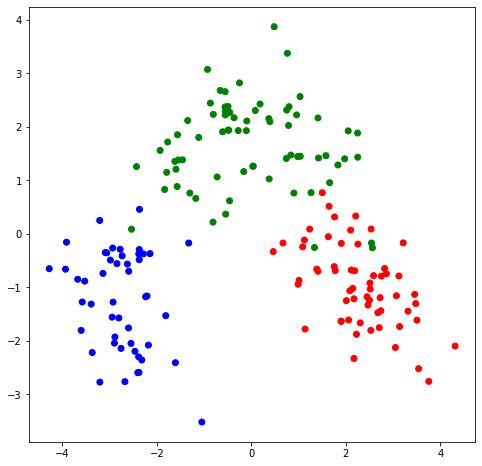

In [54]:
# Plot your two components, using the label from the data to colour the points

# Creating dataframe with PC 1, PC 2, and 'y'
df_pca_2 = pd.DataFrame(data=pca_2, columns=['PC 1', 'PC 2'])
df_pca_2['y'] = df['y'].values

x = df_pca_2['PC 1'].values
y = df_pca_2['PC 2'].values
label = df_pca_2['y'].values
colors = ['red', 'green', 'blue']

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

In [43]:
# How many components do you need to keep at least 85% of the variance in the dataset? (Q6)

pca_085, pca = std_pca(df_nolabel,0.85)
len(np.cumsum(pca.explained_variance_ratio_))

6

In [58]:
# How much variance is retained if we do PCA with 3 components? (Q7)

pca_3, pca = std_pca(df_nolabel,3)
c = np.cumsum(pca.explained_variance_ratio_)
c[-1]

0.6652996889318523

## Clustering

Let's see how many clusters does K-Means find.



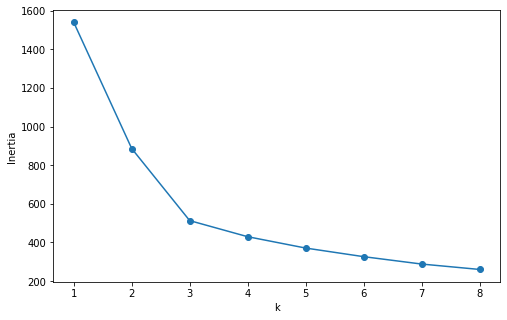

In [63]:
# Use the elbow method to select the number of clusters in your data using 3 PCs.

inertias, sil = [], []
for k in range(1, 9):
  kmeans = KMeans(n_clusters=k)
  y_pred = kmeans.fit_predict(pca_3)
  inertias.append(kmeans.inertia_)
  if k > 1:
    sil.append(silhouette_score(pca_3, y_pred))

# plotting inertia vs number of clusters
plt.figure(figsize=(8,5))
plt.plot(range(1, 9), inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

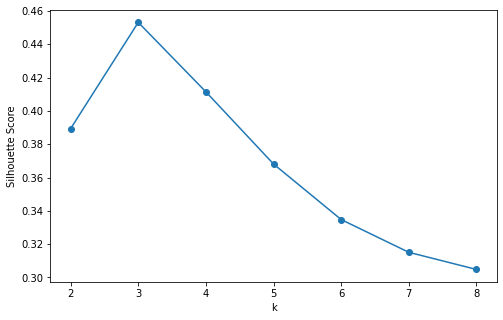

In [64]:
# Now use the silhouette score to choose between the two candidate k values from the previous cell

# plotting Silhouette Score vs number of clusters
plt.figure(figsize=(8,5))
plt.plot(range(2, 9), sil, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

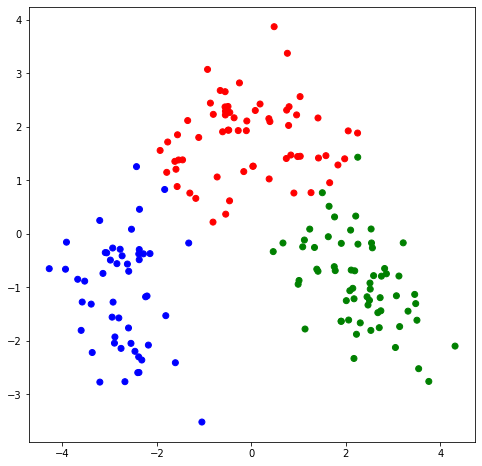

In [72]:
# Visualise the first two pcs (using a scatterplot) using the labels from KMeans with your chosen value of k

# We should keep 3 clusters
kmeans = KMeans(n_clusters=3)
y_pred = kmeans.fit_predict(pca_3)

# Creating dataframe with PC 1, PC 2, PC 3, and the predicted values from KMeans
df_pca_3 = pd.DataFrame(data=pca_3, columns=['PC 1', 'PC 2', 'PC 3'])
df_pca_3['y_pred'] = y_pred

x = df_pca_3['PC 1'].values
y = df_pca_3['PC 2'].values
label = df_pca_3['y_pred'].values
colors = ['red', 'green', 'blue']

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

Now we can try to understand our clusters.

In [73]:
# In the original (before PCA and before standardisation) dataframe, add a column called 'cluster' that contains
# the cluster assignment from above

df['cluster'] = y_pred
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,y,cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2,2


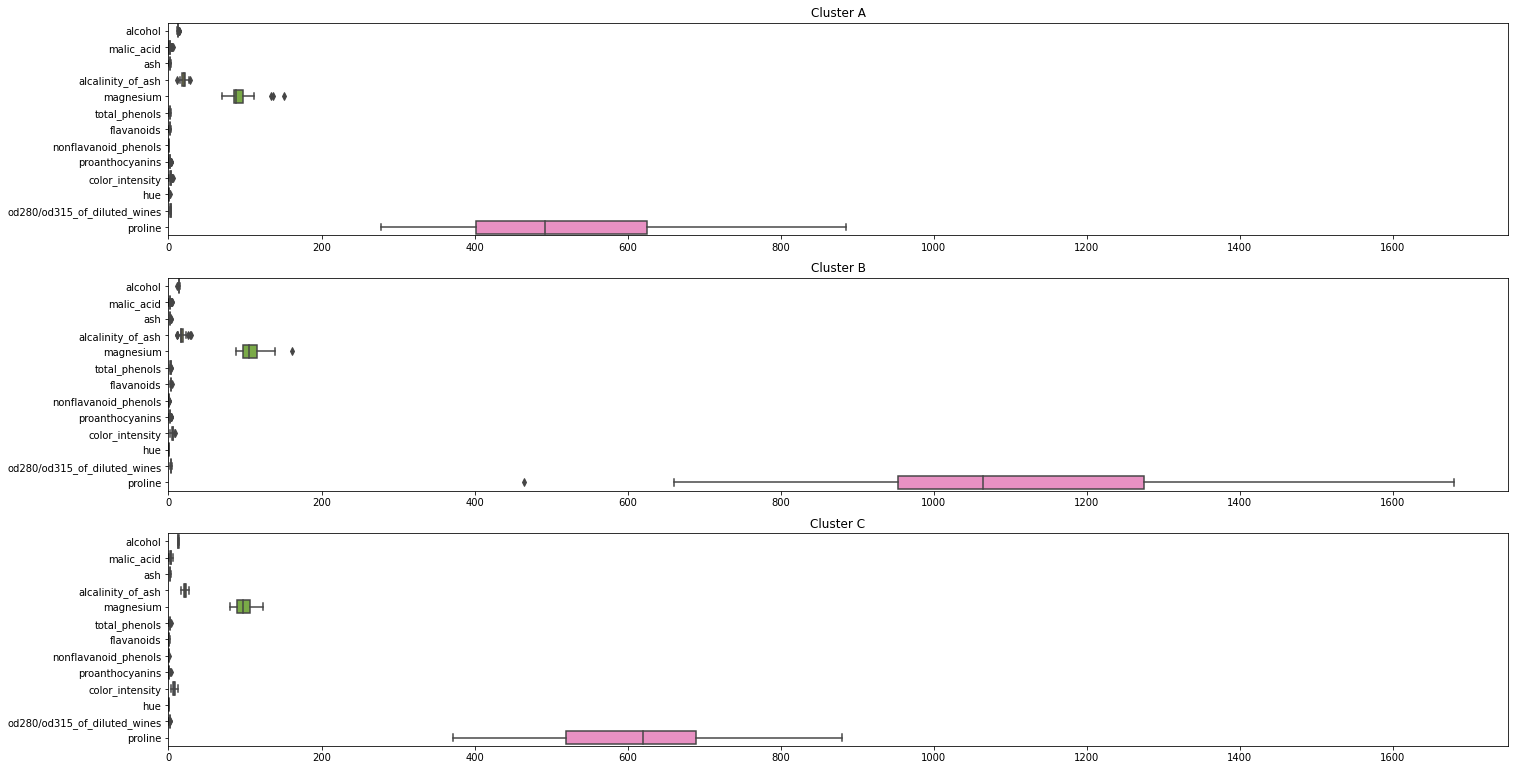

In [87]:
# Do a boxplot of each feature, separating between clusters

# Locating each clusters' indices
clusterA_idcs = df.index[df['cluster'] == 0].tolist()
clusterB_idcs = df.index[df['cluster'] == 1].tolist()
clusterC_idcs = df.index[df['cluster'] == 2].tolist()

# Separating dataframes based on the indices
clusterA = df.iloc[clusterA_idcs,:]
clusterB = df.iloc[clusterB_idcs,:]
clusterC = df.iloc[clusterC_idcs,:]

# Dropping columns 'y' and 'clusters'
A = clusterA.iloc[:,:-2]
B = clusterB.iloc[:,:-2]
C = clusterC.iloc[:,:-2]

plt.figure(figsize=(24,18))

for plot in range(1, 4):
  plt.subplot(4,1,plot)
  
  if plot == 1:
    sns.boxplot(data=A, orient="h")
    plt.title('Cluster A')
    plt.xlim([0, 1750])

  elif plot == 2:
    sns.boxplot(data=B, orient="h")
    plt.title('Cluster B')
    plt.xlim([0, 1750])

  else:
    sns.boxplot(data=C, orient="h")
    plt.title('Cluster C')
    plt.xlim([0, 1750])

plt.show()

Write your observations here.
For example: is there a clear difference between the clusters in terms of alcohol content? What about flavanoids?

Cluster B has a noticeable difference in its 'proline' distribution, with a median at around 1,100, while Cluster A's 'proline' median is around 500, and Cluster C's is around 600.

In [ ]:
# Feel free to keep playing with the data here!

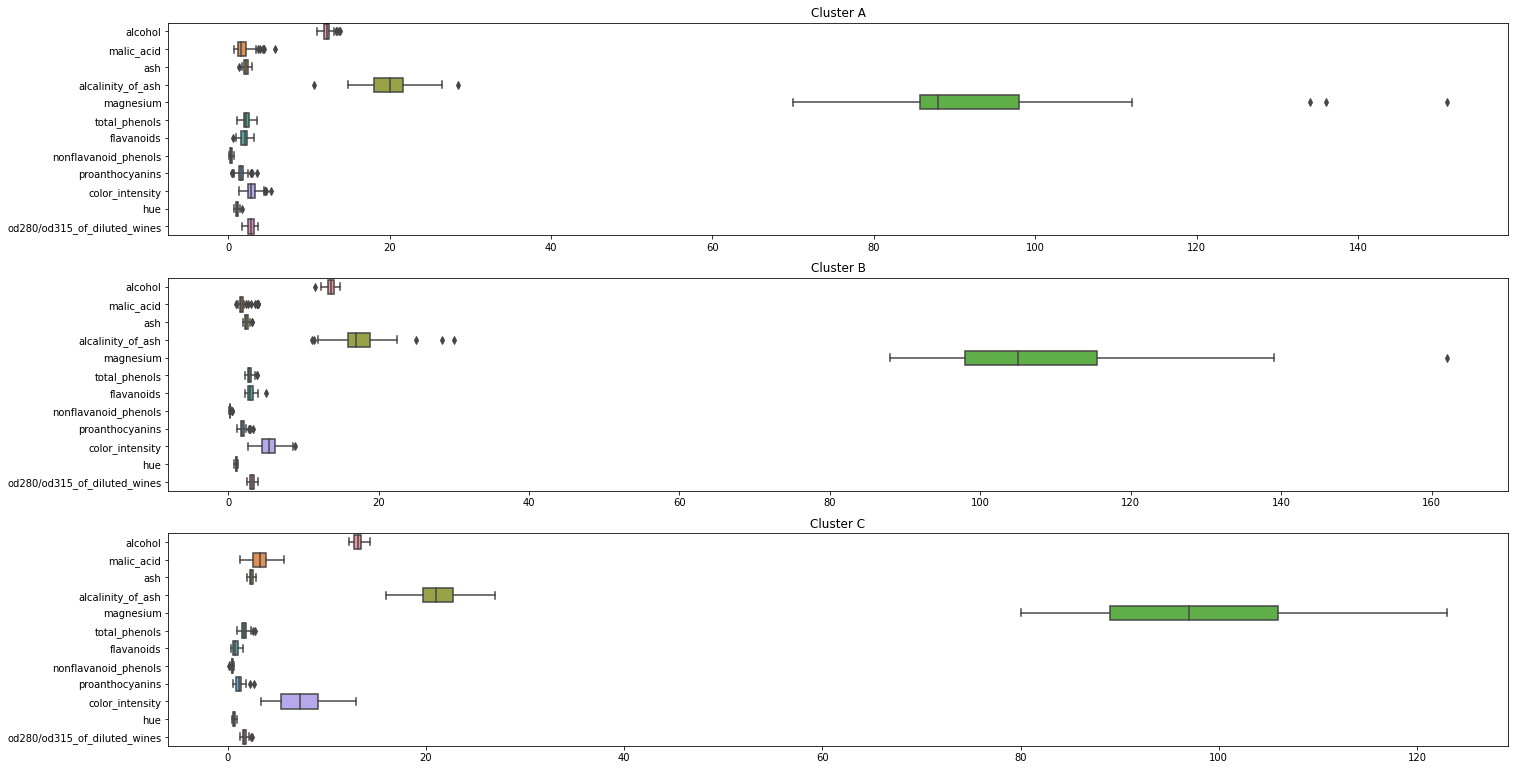

In [89]:
# Dropping columns 'proline'
A_noPro = A.iloc[:,:-1]
B_noPro = B.iloc[:,:-1]
C_noPro = C.iloc[:,:-1]

plt.figure(figsize=(24,18))

for plot in range(1, 4):
  plt.subplot(4,1,plot)
  
  if plot == 1:
    sns.boxplot(data=A_noPro, orient="h")
    plt.title('Cluster A')

  elif plot == 2:
    sns.boxplot(data=B_noPro, orient="h")
    plt.title('Cluster B')

  else:
    sns.boxplot(data=C_noPro, orient="h")
    plt.title('Cluster C')

plt.show()

After plotting without 'proline' we can also observe that Cluster B's 'alcalinity_of_ash' has a lower distribution than those of the other two clusters, with a median of around 13.

A noticeable difference between Clusters A and C is that the latter's 'color intensity', 'alcalinity of ash', 'alcohol', and 'malic acid' medians are larger, while its 'flavanoids' and 'od280/od315 of diluted wines' medians are lower.